# Model evaluation example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import xarray
import dask

dask.config.set(scheduler="processes")

## Precipitation

Precipitation is a highly variable quantity and can show significant differences between ensemble runs, especially at regional scales. It's influenced by small perturbations in atmospheric circulation, and localized differences can amplify over time. Precipitation is subject to chaotic behavior in atmospheric circulation, so small differences in initial conditions can lead to large differences in how and where precipitation forms.

In [2]:
members = [
    b'r10i1p1f1', b'r10i1p2f1',
    # b'r1i1p1f1', b'r1i1p2f1',  # bad join existing
    b'r2i1p1f1', b'r2i1p2f1',
    b'r3i1p1f1', b'r3i1p2f1',
    b'r4i1p1f1', b'r4i1p2f1',
    b'r5i1p1f1', b'r5i1p2f1',
    b'r6i1p1f1', b'r6i1p2f1',
    b'r7i1p1f1', b'r7i1p2f1',
    b'r8i1p1f1', b'r8i1p2f1',
    b'r9i1p1f1', b'r9i1p2f1',
]

hist_ref_1850_1900 = slice("18500101", "19001231")
hist_ref_1995_2014 = slice("19950101", "20141231")
fut_ref = slice("20800101", "21001231")
lats, lons = slice(30, 75), slice(155, 225)

In [3]:
%%time

ssp126 = xarray.open_dataset("https://hub.climate4r.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/Amon/CMIP6_ScenarioMIP_CCCma_CanESM5_ssp126_Amon_gn_v20190429/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CCCma_CanESM5_ssp126_Amon_pr_gn_v20190429.ncml").drop_dims(["nfiles", "file"]).sel(variant_label=members)
ssp585 = xarray.open_dataset("https://hub.climate4r.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/Amon/CMIP6_ScenarioMIP_CCCma_CanESM5_ssp585_Amon_gn_v20190429/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CCCma_CanESM5_ssp585_Amon_pr_gn_v20190429.ncml").drop_dims(["nfiles", "file"]).sel(variant_label=members)

historical = xarray.open_dataset("https://hub.climate4r.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/Amon/CMIP6_CMIP_CCCma_CanESM5_historical_Amon_gn_v20190429/replicas/esgf.ceda.ac.uk/CMIP6_CMIP_CCCma_CanESM5_historical_Amon_pr_gn_v20190429.ncml").sel(variant_label=members)
scenarios = xarray.concat([ssp126, ssp585], dim=xarray.Variable(["scenario"], ["ssp126", "ssp585"]))

CPU times: user 16.7 s, sys: 3.86 s, total: 20.6 s
Wall time: 2min 49s


Calculate the anomaly by computing the difference between both climatologies for both future scenarios. Calculate both the absolute and relative anomalies.

In [4]:
%%time

delta = (
    scenarios["pr"].sel(lat=lats, lon=lons, time=fut_ref).mean("time") -
    historical["pr"].sel(lat=lats, lon=lons, time=hist_ref_1995_2014).mean("time"))

delta_rel = (delta / historical["pr"].sel(lat=lats, lon=lons, time=hist_ref_1995_2014).mean("time")) * 100

CPU times: user 413 ms, sys: 43.6 ms, total: 457 ms
Wall time: 8.01 s


Compare the multi-ensemble mean for both scenarios.

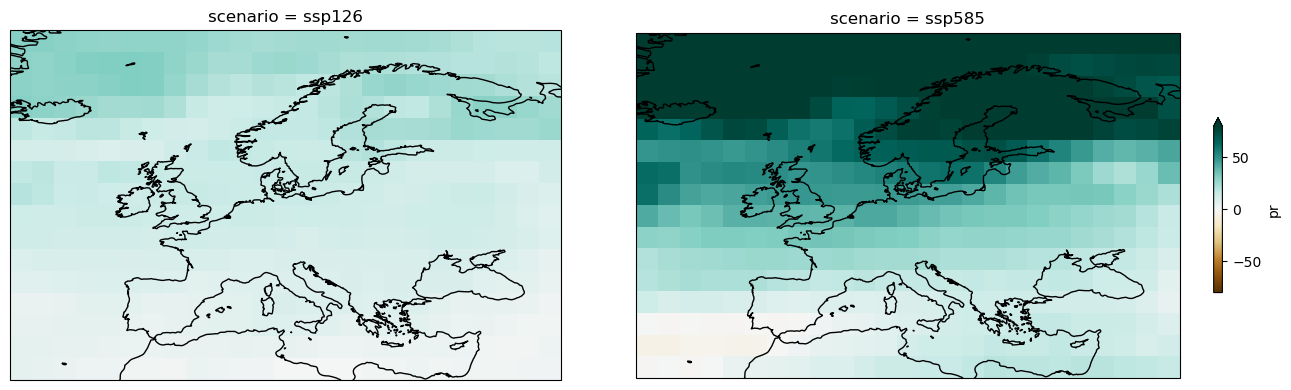

In [6]:
fig, axes = plt.subplots(1,2,figsize=(14,4),subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0)),)

delta_rel.sel(scenario="ssp126").mean("variant_label").plot(
    ax=axes[0],
    add_colorbar=False,
    cmap="BrBG",
    #cbar_kwargs={"shrink": .5},
    vmin=-80, vmax=80,
    transform=ccrs.PlateCarree(central_longitude=180))

delta_rel.sel(scenario="ssp585").mean("variant_label").plot(
    ax=axes[1],
    add_colorbar=True,
    cmap="BrBG",
    cbar_kwargs={"shrink": .5},
    vmin=-80, vmax=80,
    transform=ccrs.PlateCarree(central_longitude=180))

axes[0].coastlines()
axes[1].coastlines()

plt.tight_layout()
plt.savefig("pr-deltas.svg")

Visualize the relative deltas (anomalies) for each ensemble member for one of the scenarios.

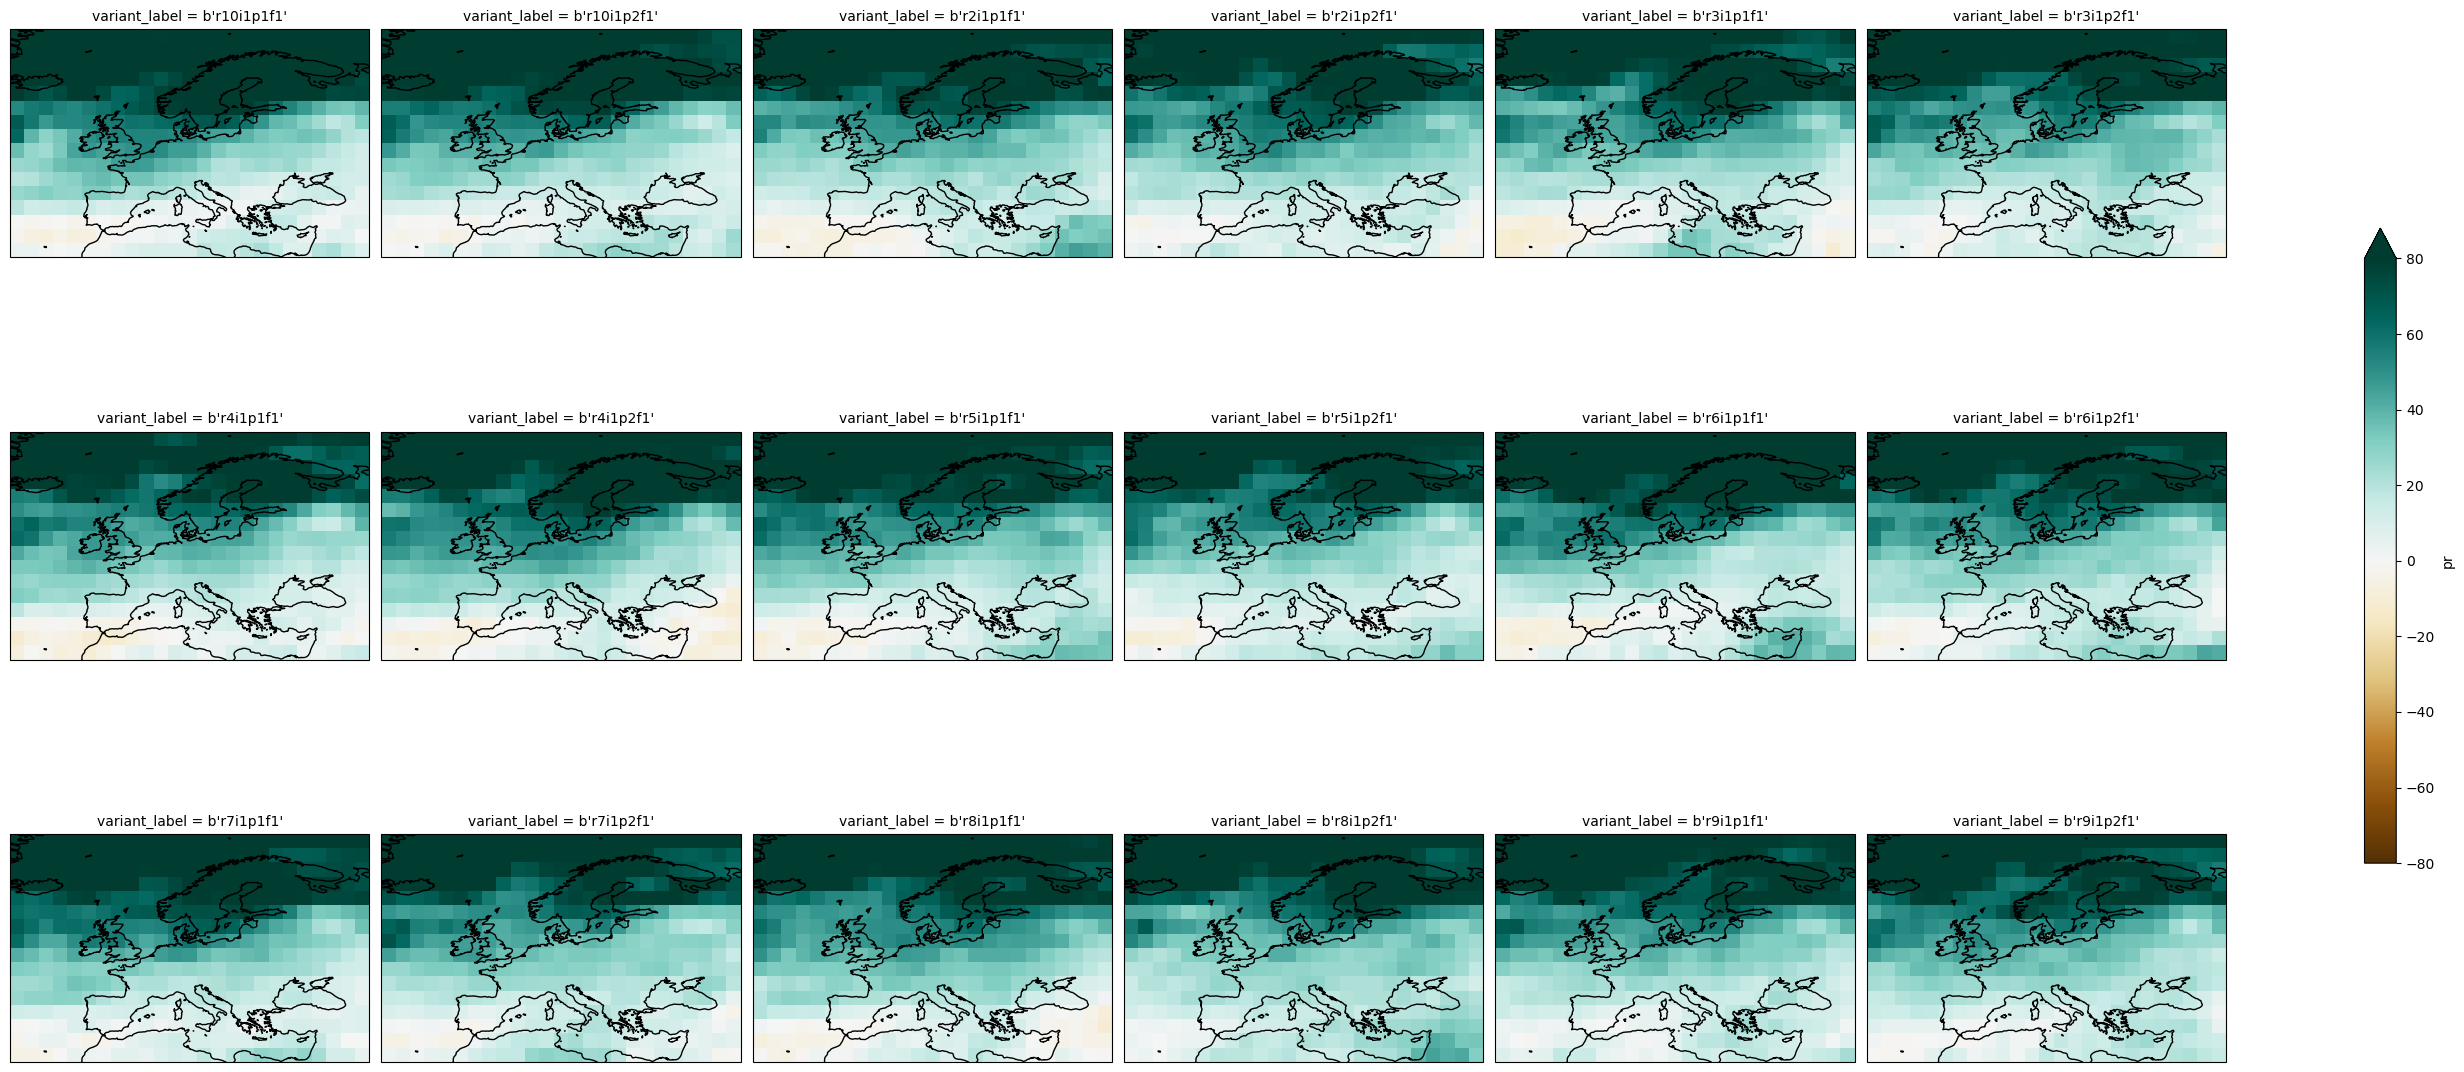

In [13]:
plot = delta_rel.sel(scenario="ssp585").plot(
    x="lon", y="lat", col="variant_label", col_wrap=6,
    figsize=(28,13),
    add_colorbar=True,
    cmap="BrBG",
    vmin=-80, vmax=80,
    cbar_kwargs={"shrink": .5},
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree(central_longitude=180))

for ax in plot.axs.flatten():
    ax.coastlines()

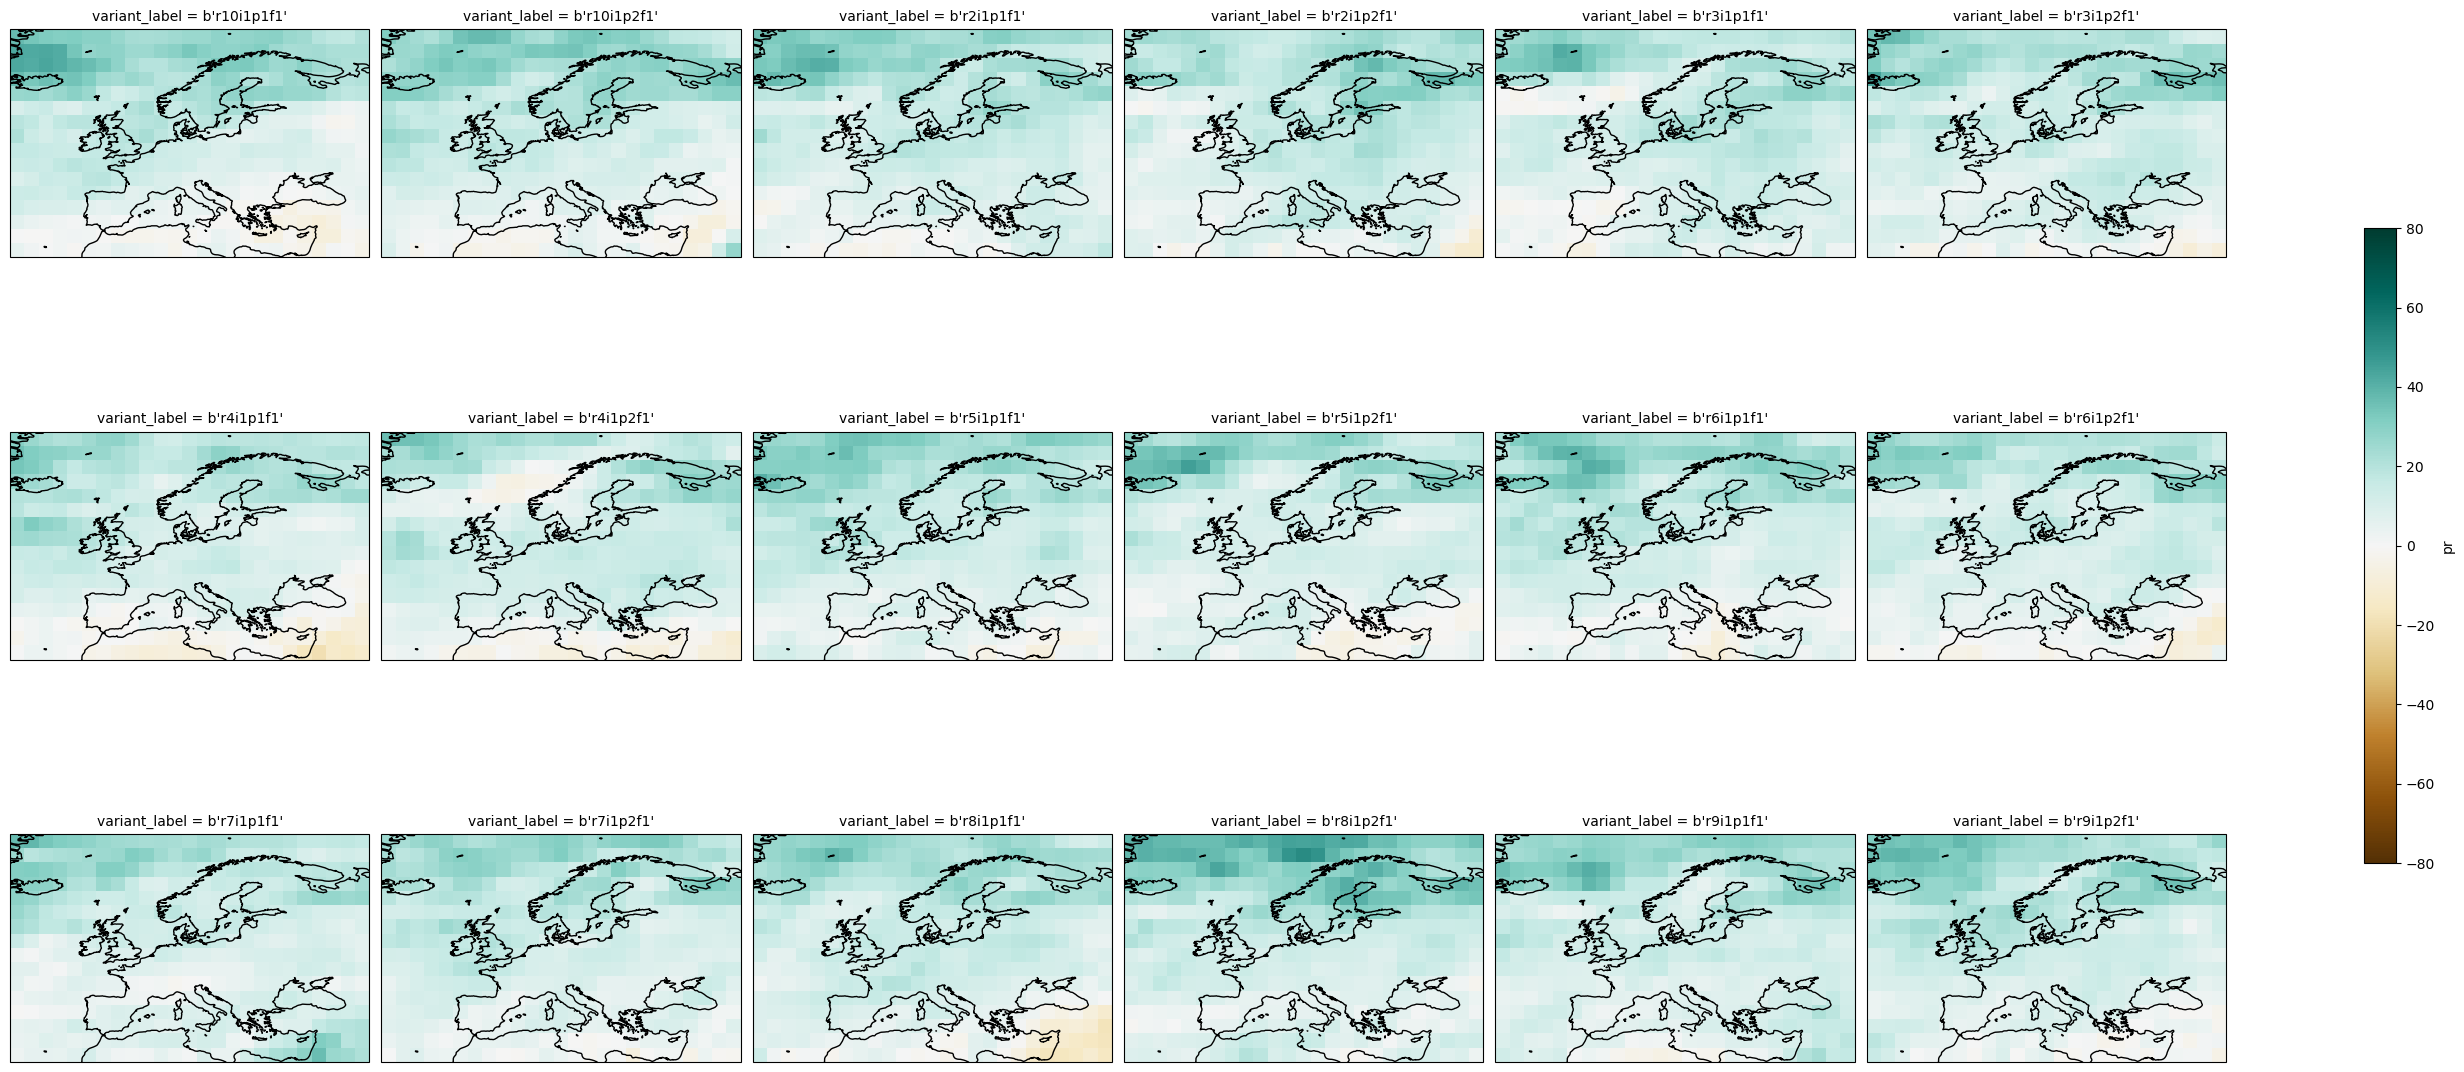

In [8]:
plot = delta_rel.sel(scenario="ssp126").plot(
    x="lon", y="lat", col="variant_label", col_wrap=6,
    figsize=(28,13),
    add_colorbar=True,
    cmap="BrBG",
    vmin=-80, vmax=80,
    cbar_kwargs={"shrink": .5},
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree(central_longitude=180))

for ax in plot.axs.flatten():
    ax.coastlines()

## Model member agreement

In [9]:
def model_agreement(da, axis, th = 80):
    nmembers, nlat, nlon = da.shape
    mask = np.array([
        (da[:,i,j] > 0).sum() > int(nmembers * th / 100)
        if da[:,i,j].mean() > 0
        else (da[:,i,j] < 0).sum() > int(nmembers * th / 100)
        for i in range(nlat)
        for j in range(nlon)]).reshape((nlat,nlon))
    
    return mask

def hatching(plot, mask, data):
    rows, cols = mask.shape
    for i in range(rows):
        for j in range(cols):
            lat, lon = data["lat"][i].item(), data["lon"][j].item()
            if mask[i,j]:
                plot.axes.plot([lon-1.39,lon+1.39],[lat+1.39,lat-1.39],'-',c="black", linewidth=.5, transform=ccrs.PlateCarree(central_longitude=180))

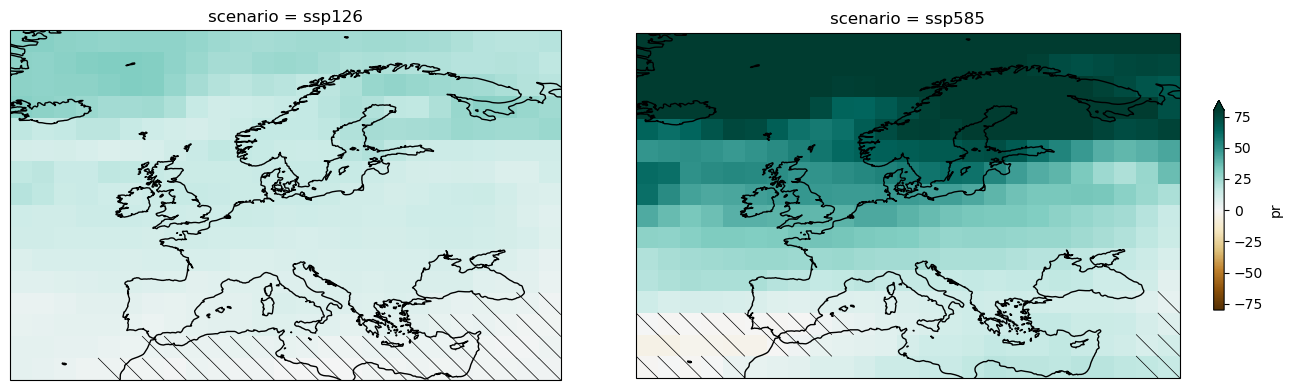

In [19]:
fig, axes = plt.subplots(1,2,figsize=(14,4),subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0)))

ens_mean_ssp126 = delta_rel.sel(scenario="ssp126").mean("variant_label")
ens_mean_ssp585 = delta_rel.sel(scenario="ssp585").mean("variant_label")

mask_ssp126 = delta.sel(scenario="ssp126").reduce(model_agreement, "variant_label")
mask_ssp585 = delta.sel(scenario="ssp585").reduce(model_agreement, "variant_label")

plot_ssp126 = ens_mean_ssp126.plot(
    ax=axes[0],
    add_colorbar=False,
    cmap="BrBG",
    #cbar_kwargs={"shrink": .5},
    vmin=-80, vmax=80,
    transform=ccrs.PlateCarree(central_longitude=180))

plot_ssp585 = ens_mean_ssp585.plot(
    ax=axes[1],
    add_colorbar=True,
    cmap="BrBG",
    cbar_kwargs={"shrink": .6},
    vmin=-80, vmax=80,
    transform=ccrs.PlateCarree(central_longitude=180))

axes[0].coastlines()
axes[1].coastlines()

hatching(plot_ssp126, ~mask_ssp126, ens_mean_ssp126)
hatching(plot_ssp585, ~mask_ssp585, ens_mean_ssp585)

plt.tight_layout()
plt.savefig("pr-deltas.svg")

# Temperature

## 5 model members (19 for historical)

In [20]:
ssp126 = xarray.open_dataset("https://hub.climate4r.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/Amon/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp126_Amon_gr_v20190410/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp126_Amon_pr_gr_v20190410.ncml").chunk(variant_label=1, time=100)
ssp245 = xarray.open_dataset("https://hub.climate4r.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/Amon/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp245_Amon_gr_v20190410/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp245_Amon_pr_gr_v20190410.ncml").chunk(variant_label=1, time=100)
ssp370 = xarray.open_dataset("https://hub.climate4r.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/Amon/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp370_Amon_gr_v20190410/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp370_Amon_pr_gr_v20190410.ncml").chunk(variant_label=1, time=100)
ssp585 = xarray.open_dataset("https://hub.climate4r.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/Amon/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp585_Amon_gr_v20190410/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp585_Amon_pr_gr_v20190410.ncml").chunk(variant_label=1, time=100)

historical = xarray.open_dataset("https://hub.climate4r.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/Amon/CMIP6_CMIP_CNRM-CERFACS_CNRM-CM6-1_historical_Amon_gr_v20190125/replicas/esgf.ceda.ac.uk/CMIP6_CMIP_CNRM-CERFACS_CNRM-CM6-1_historical_Amon_pr_gr_v20190125.ncml").chunk(variant_label=1, time=100)
scenarios = xarray.concat([ssp126, ssp245, ssp370, ssp585], dim=xarray.Variable(["scenario"], ["ssp126", "ssp245", "ssp370", "ssp585"]))

In [3]:
%%time

weights = np.cos(np.deg2rad(scenarios["lat"]))
mean_hist_1995_2014 = historical["tas"].sel(time=slice("19950101", "20141231")).weighted(weights).mean(["time", "lat", "lon"]).compute(num_worker=4)

historical_mean = historical["tas"].weighted(weights).mean(["variant_label", "lat", "lon"]).compute(num_worker=4)
scenarios_mean = scenarios["tas"].weighted(weights).mean(["variant_label", "lat", "lon"]).compute(num_worker=4)

historical_mean_spatial = historical["tas"].weighted(weights).mean(["lat", "lon"]).compute(num_worker=4)
scenarios_mean_spatial = scenarios["tas"].weighted(weights).mean(["lat", "lon"]).compute(num_worker=4)

q = scenarios_mean_spatial.resample(time="Y").mean().quantile([.05, .95], dim=["variant_label"])

CPU times: user 15.9 s, sys: 21.6 s, total: 37.5 s
Wall time: 11min 17s


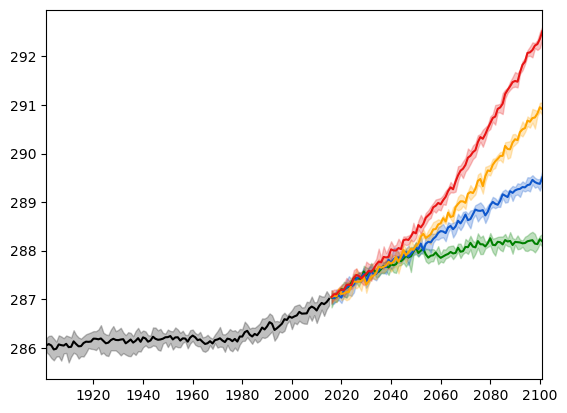

In [4]:
fig, ax = plt.subplots()

colors = {
    "ssp126": "green",
    "ssp245": "#0e57cc",
    "ssp370": "orange",
    "ssp585": "#e81515",
}

for scenario_da in scenarios["scenario"]:
    sc = scenario_da.item()
    ax.plot(
        scenarios_mean.sel(scenario=sc).resample(time="Y").mean().time,
        scenarios_mean.sel(scenario=sc).resample(time="Y").mean(),
        color=colors[sc])
    ax.fill_between(
        q.time,
        q.sel(scenario=sc, quantile=.05),
        q.sel(scenario=sc, quantile=.95),
        color=colors[sc], alpha=.25)

qh = historical_mean_spatial.resample(time="Y").mean().quantile([.05, .95], dim=["variant_label"])
ax.plot(
    historical_mean.resample(time="Y").mean().sel(time=slice("19000101", None)).time,
    historical_mean.resample(time="Y").mean().sel(time=slice("19000101", None)),
    color="black")
ax.fill_between(
    qh.sel(time=slice("19000101", None)).time,
    qh.sel(time=slice("19000101", None)).sel(quantile=.05),
    qh.sel(time=slice("19000101", None)).sel(quantile=.95),
    color="black", alpha=.25)

plt.margins(x=0)

## 50 model members (65 for historical)

In [5]:
ssp119 = xarray.open_dataset("https://hub.climate4r.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/Amon/CMIP6_ScenarioMIP_CCCma_CanESM5_ssp119_Amon_gn_v20190429/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CCCma_CanESM5_ssp119_Amon_tas_gn_v20190429.ncml").drop_dims(["nfiles", "file"]).chunk(variant_label=1, time=100)
ssp585 = xarray.open_dataset("https://hub.climate4r.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/Amon/CMIP6_ScenarioMIP_CCCma_CanESM5_ssp585_Amon_gn_v20190429/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CCCma_CanESM5_ssp585_Amon_tas_gn_v20190429.ncml").drop_dims(["nfiles", "file"]).chunk(variant_label=1, time=100)

historical = xarray.open_dataset("https://hub.climate4r.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/Amon/CMIP6_CMIP_CCCma_CanESM5_historical_Amon_gn_v20190429/replicas/esgf.ceda.ac.uk/CMIP6_CMIP_CCCma_CanESM5_historical_Amon_tas_gn_v20190429.ncml").chunk(variant_label=1, time=100)
scenarios = xarray.concat([ssp119, ssp585], dim=xarray.Variable(["scenario"], ["ssp119", "ssp585"]))

In [6]:
%%time

weights = np.cos(np.deg2rad(scenarios["lat"]))
mean_hist_1995_2014 = historical["tas"].sel(time=slice("19950101", "20141231")).weighted(weights).mean(["time", "lat", "lon"]).compute(num_worker=4)

historical_mean = historical["tas"].weighted(weights).mean(["variant_label", "lat", "lon"]).compute(num_worker=4)
scenarios_mean = scenarios["tas"].weighted(weights).mean(["variant_label", "lat", "lon"]).compute(num_worker=4)

historical_mean_spatial = historical["tas"].weighted(weights).mean(["lat", "lon"]).compute(num_worker=4)
scenarios_mean_spatial = scenarios["tas"].weighted(weights).mean(["lat", "lon"]).compute(num_worker=4)

CPU times: user 29.5 s, sys: 17 s, total: 46.4 s
Wall time: 39min 7s


In [7]:
q = scenarios_mean_spatial.resample(time="Y").mean().quantile([.05, .95], dim=["variant_label"])

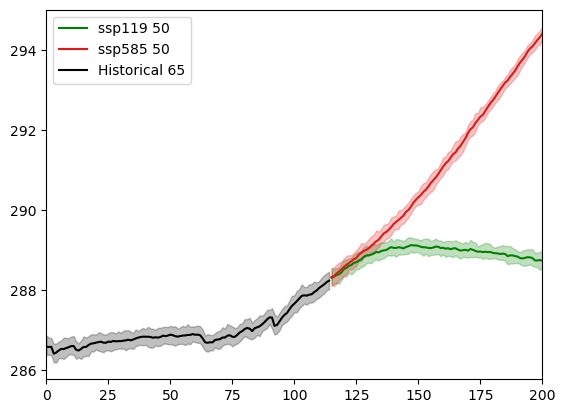

In [18]:
fig, ax = plt.subplots()

colors = {
    "ssp119": "green",
    "ssp245": "#0e57cc",
    "ssp370": "orange",
    "ssp585": "#e81515",
}
n_scenarios = len(scenarios_mean.sel(scenario=sc).resample(time="Y").mean().time)
n_historical = len(historical_mean.resample(time="Y").mean().sel(time=slice("19000101", None)))

for scenario_da in scenarios["scenario"]:
    sc = scenario_da.item()
    ax.plot(
        range(n_historical,n_historical+n_scenarios),
        scenarios_mean.sel(scenario=sc).resample(time="Y").mean(),
        color=colors[sc], label=f"{sc} {len(scenarios['variant_label'])}")
    ax.fill_between(
        range(n_historical,n_historical+n_scenarios),
        q.sel(scenario=sc, quantile=.05),
        q.sel(scenario=sc, quantile=.95),
        color=colors[sc], alpha=.25)

qh = historical_mean_spatial.resample(time="Y").mean().quantile([.05, .95], dim=["variant_label"])
ax.plot(
    range(n_historical),
    historical_mean.resample(time="Y").mean().sel(time=slice("19000101", None)),
    color="black", label=f"Historical {len(historical['variant_label'])}")
ax.fill_between(
    range(n_historical),
    qh.sel(time=slice("19000101", None)).sel(quantile=.05),
    qh.sel(time=slice("19000101", None)).sel(quantile=.95),
    color="black", alpha=.25)

ax.legend()
plt.margins(x=0)